In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Notebooks/Repository/go-emotions/notebooks

Mounted at /content/drive
/content/drive/MyDrive/Notebooks/Repository/go-emotions/notebooks


In [2]:
%run library_utils.ipynb

import os 
import numpy as np 
import matplotlib.pyplot as plt
import torch 
import transformers
assert transformers.__version__ >= '4.17.0'
from transformers import (
    AutoTokenizer, 
    AutoModel)
from tqdm import tqdm
from torch import Tensor
import torch.nn as nn

tqdm.pandas()

module = 'go-emotion-gru'
filename = os.getcwd() + '/model.py'
args = load_args(module)
init_seed(args.seed)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
     |████████████████████████████████| 3.8 MB 6.2 MB/s 
     |████████████████████████████████| 895 kB 35.0 MB/s 
     |████████████████████████████████| 596 kB 49.5 MB/s 
     |████████████████████████████████| 6.5 MB 50.5 MB/s 
     |████████████████████████████████| 67 kB 5.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
device: cuda


In [3]:
args.model_name = 'go-emotion-gru-mini'
args.encoder_name = 'prajjwal1/bert-mini'
args.fc_hiddens = (75, 75)

### Tokenizer & Encoder

In [4]:
tokenizer = AutoTokenizer.from_pretrained(args.encoder_name)
encoder = AutoModel.from_pretrained(args.encoder_name)

Downloading:   0%|          | 0.00/286 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/43.0M [00:00<?, ?B/s]

Some weights of the model checkpoint at prajjwal1/bert-mini were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
X_tk = tokenize_bert_inputs(
  ['hello my name is jeongwon', 'what are you?'], 
  tokenizer, 
  maxlen=args.sentence_max_len
)
len(X_tk['input_ids'][0])

62

In [6]:
%%time
dataset_path = os.path.join(args.output_dir, args.train_dataset_path)
assert os.path.exists(dataset_path)

train_dataset, val_dataset = generate_bert_dataset(
    dataset_path,     
    tokenizer, 
    emotions = args.emotions, 
    sentence_max_len = args.sentence_max_len, 
    split = args.validation_split_from_train
)

CPU times: user 12.8 s, sys: 672 ms, total: 13.5 s
Wall time: 11.2 s


In [7]:
# |%%writefile -a $filename

class GoEmotionGRUClassifer(TransformerEncoderBase):
  def __init__(self, 
        encoder, 
        criterion=nn.BCEWithLogitsLoss(), 
        seq_len=82,
        rnn_hidden = 50,  
        rnn_num_layers = 1,
        bidirectional=True, 
        hiddens = None,
        dropout_p=0.1, 
        n_cls:int = 28
    ):
    config = {
        'seq_len': seq_len, 
        'rnn_hidden': rnn_hidden, 
        'rnn_num_layers': rnn_num_layers, 
        'bidirectional': bidirectional, 
        'hiddens':  [50] if hiddens is None else hiddens, 
        'dropout_p': dropout_p, 
        'n_cls': n_cls
    }
    super().__init__(encoder, criterion, config)

    # layers
    self.encoder = encoder
    self.gru = nn.GRU(
        input_size= self.encoder_dim, 
        hidden_size = rnn_hidden, 
        batch_first = True, 
        bidirectional = bidirectional
    )
    self.dropout = nn.Dropout(dropout_p)

    # full connected
    fcs = []
    in_feature = (int(bidirectional) + 1) * rnn_hidden
    for h in self.config['hiddens']:
      fcs.append(nn.Linear(in_feature, h))
      fcs.append(nn.ReLU())
      in_feature = h    
    
    # final layer 
    fcs.append(nn.Linear(in_feature, n_cls))
    self.fcs = nn.Sequential(*fcs)

  def forward(self, input_ids, attention_mask, y_true=None):
    encoder_output = super().forward(input_ids, attention_mask)
    contextual_emb = encoder_output['last_hidden_state']

    output, _ = self.gru(contextual_emb)
    output = output[:, -1, :]
    z = self.dropout(output) 
    logits = self.fcs(z)

    if not (y_true is None):
      loss = self.criterion(logits, y_true)
      return (loss, logits)

    return logits


In [8]:
def create_go_emotion_gru(args, encoder):
    return GoEmotionGRUClassifer(
        encoder, 
        seq_len=args.sentence_max_len,
        rnn_hidden=args.rnn_hidden, 
        rnn_num_layers = args.rnn_num_layers, 
        bidirectional=args.bidirectional, 
        hiddens = args.fc_hiddens, 
        dropout_p = args.dropout_p, 
        n_cls = len(args.emotions)
    )

model = create_go_emotion_gru(args, encoder)
model

GoEmotionGRUClassifer(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 256, padding_idx=0)
      (position_embeddings): Embedding(512, 256)
      (token_type_embeddings): Embedding(2, 256)
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=256, out_features=256, bias=True)
              (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_

In [9]:
def proba_on_examples(texts, model):
    X_tk = tokenize_bert_inputs(
        texts, tokenizer, maxlen = args.sentence_max_len
    )
    X_tk['input_ids'] = Tensor(X_tk['input_ids']).type(torch.int32)
    X_tk['attention_mask'] = Tensor(X_tk['attention_mask']).type(torch.int32)
    proba = predict_proba_examples(X_tk, model)
    return proba

In [10]:
proba = proba_on_examples(['hello my name is jeongwon', 'nice to meet you!'], model)
proba_to_emotion(
    proba,
    args.classification_threshold, 
    args.emotions, 
)[0][:3]

[('admiration', 0.5172467), ('amusement', 0.5523306), ('anger', 0.49727455)]

In [11]:
proba = predict_proba_examples(val_dataset[:5], model)
y_true = val_dataset[:5]['y_true'].numpy()
compute_classification_metrics(y_true, proba, 0.1)

{'accuracy': 0.044444444444444446,
 'macro_f1': 0.0670194003527337,
 'macro_precision': 0.044444444444444446,
 'macro_recall': 0.14814814814814814,
 'micro_f1': 0.0851063829787234,
 'micro_precision': 0.044444444444444446,
 'micro_recall': 1.0,
 'weighted_f1': 0.49206349206349215,
 'weighted_precision': 0.3333333333333333,
 'weighted_recall': 1.0}

In [12]:
evaluate(
    model, 
    val_dataset, 
    batch_size = args.eval_batch_size, 
    threshold = args.classification_threshold, 
    device = args.device
)

{'accuracy': 0.04695688599307007,
 'auc_roc_macro': 0.5093917021239491,
 'auc_roc_micro': 0.47577911721638405,
 'loss': 0.6966249999025077,
 'macro_f1': 0.0882997470479051,
 'macro_precision': 0.04695688599307007,
 'macro_recall': 1.0,
 'micro_f1': 0.0897016613029486,
 'micro_precision': 0.04695688599307007,
 'micro_recall': 1.0,
 'trigger_rate': 1.0,
 'weighted_f1': 0.11955701106465137,
 'weighted_precision': 0.0643399480933103,
 'weighted_recall': 1.0}

In [13]:
model = create_go_emotion_gru(args, encoder)
_ = save_checkpoint(
    model, 
    args.output_dir, 
    model_name='testmodel',
    metadata=args
)

model_copy, _ = load_from_checkpoint(
    args.output_dir,
    model_name='testmodel',
    checkpoint_id='null-model', 
    model_cls=GoEmotionGRUClassifer
)

check_model_same(model, model_copy)

True

In [15]:
# clear_archive(args.output_dir, args.model_name)

In [16]:
model = create_go_emotion_gru(args, encoder)
model, metadata = train(
    model, 
    train_dataset, 
    val_dataset, 
    dict(args), 
    tokenizer, 
    epochs=args.train_epochs, 
    train_batch_size = args.train_batch_size, 
    val_batch_size = args.eval_batch_size, 
    save_steps = args.save_steps, 
    validation_steps= args.validation_steps, 
    archive_dir = args.output_dir, 
    model_name = args.model_name, 
    classification_threshold = args.classification_threshold, 
    learning_rate = args.learning_rate, 
    grad_clip_max = args.grad_clip_max, 
    weight_decay = args.weight_decay, 
    warmup_ratio = args.warmup_ratio, 
    logging_metrics= ['macro_f1', 'macro_precision', 'macro_recall'],
    continue_training=False,
    device = args.device
)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


training epoch 0


evaluation: 100%|█████████▉| 1519/1526 [00:11<00:00, 125.16it/s]
                                                                
evaluation:  99%|█████████▉| 1517/1525 [00:16<00:00, 123.97it/s]
                                                                

evaluating at step 3000
val {'macro_precision': 0.05047003647122472, 'macro_recall': 0.8894480994449432, 'macro_f1': 0.07567044360230943}
tr {'macro_precision': 0.0478025141109537, 'macro_recall': 0.8892740694439875, 'macro_f1': 0.0759139642521681}
saving at step 3000


evaluation: 100%|█████████▉| 1522/1526 [00:12<00:00, 126.30it/s]
                                                                
evaluation: 100%|█████████▉| 1523/1525 [00:12<00:00, 124.40it/s]
                                                                

evaluating at step 6000
val {'macro_precision': 0.001954829476035885, 'macro_recall': 0.037037037037037035, 'macro_f1': 0.0037136509831227826}
tr {'macro_precision': 0.0020264116575591986, 'macro_recall': 0.037037037037037035, 'macro_f1': 0.0038425835977808}
saving at step 6000


Training: 100%|██████████| 6101/6101 [04:02<00:00, 25.12it/s]


training epoch 1


evaluation: 100%|█████████▉| 1523/1526 [00:12<00:00, 119.51it/s]
                                                                
evaluation: 100%|█████████▉| 1523/1525 [00:12<00:00, 125.96it/s]
                                                                

evaluating at step 9000
val {'macro_precision': 0.0, 'macro_recall': 0.0, 'macro_f1': 0.0}
tr {'macro_precision': 0.0, 'macro_recall': 0.0, 'macro_f1': 0.0}
saving at step 9000


evaluation: 100%|█████████▉| 1522/1526 [00:12<00:00, 126.88it/s]
                                                                
evaluation: 100%|█████████▉| 1518/1525 [00:12<00:00, 124.26it/s]
                                                                

evaluating at step 12000
val {'macro_precision': 0.0, 'macro_recall': 0.0, 'macro_f1': 0.0}
tr {'macro_precision': 0.0, 'macro_recall': 0.0, 'macro_f1': 0.0}
saving at step 12000


Training: 100%|██████████| 6101/6101 [03:56<00:00, 25.75it/s]


training epoch 2


evaluation: 100%|█████████▉| 1524/1526 [00:12<00:00, 119.79it/s]
                                                                
evaluation:  99%|█████████▉| 1514/1525 [00:12<00:00, 120.95it/s]
                                                                

evaluating at step 15000
val {'macro_precision': 0.0, 'macro_recall': 0.0, 'macro_f1': 0.0}
tr {'macro_precision': 0.0, 'macro_recall': 0.0, 'macro_f1': 0.0}
saving at step 15000


evaluation: 100%|█████████▉| 1523/1526 [00:12<00:00, 126.93it/s]
                                                                
evaluation:  99%|█████████▉| 1513/1525 [00:12<00:00, 122.94it/s]
                                                                

evaluating at step 18000
val {'macro_precision': 0.0, 'macro_recall': 0.0, 'macro_f1': 0.0}
tr {'macro_precision': 0.0, 'macro_recall': 0.0, 'macro_f1': 0.0}
saving at step 18000


Training: 100%|██████████| 6101/6101 [03:57<00:00, 25.66it/s]


training epoch 3


evaluation: 100%|█████████▉| 1520/1526 [00:11<00:00, 128.19it/s]
                                                                
evaluation: 100%|█████████▉| 1524/1525 [00:12<00:00, 127.15it/s]
                                                                

evaluating at step 21000
val {'macro_precision': 0.0, 'macro_recall': 0.0, 'macro_f1': 0.0}
tr {'macro_precision': 0.0, 'macro_recall': 0.0, 'macro_f1': 0.0}
saving at step 21000


evaluation:  99%|█████████▉| 1518/1526 [00:12<00:00, 129.36it/s]
                                                                
evaluation:  99%|█████████▉| 1513/1525 [00:12<00:00, 121.23it/s]
                                                                

evaluating at step 24000
val {'macro_precision': 0.0, 'macro_recall': 0.0, 'macro_f1': 0.0}
tr {'macro_precision': 0.0, 'macro_recall': 0.0, 'macro_f1': 0.0}
saving at step 24000


Training: 100%|██████████| 6101/6101 [03:58<00:00, 25.63it/s]


training epoch 4


evaluation:  99%|█████████▉| 1515/1526 [00:12<00:00, 121.82it/s]
                                                                
evaluation: 100%|█████████▉| 1519/1525 [00:12<00:00, 124.62it/s]
                                                                

evaluating at step 27000
val {'macro_precision': 0.030323788646846598, 'macro_recall': 0.026443647949024294, 'macro_f1': 0.028251111536579658}
tr {'macro_precision': 0.03959018189787421, 'macro_recall': 0.027202625235894323, 'macro_f1': 0.02871597289941809}
saving at step 27000


evaluation: 100%|█████████▉| 1523/1526 [00:12<00:00, 124.29it/s]
                                                                
evaluation: 100%|█████████▉| 1518/1525 [00:12<00:00, 125.08it/s]
                                                                

evaluating at step 30000
val {'macro_precision': 0.0968343776188262, 'macro_recall': 0.03920623897375162, 'macro_f1': 0.04891013144624862}
tr {'macro_precision': 0.0953399019947071, 'macro_recall': 0.03856285480654487, 'macro_f1': 0.04741198047099699}
saving at step 30000


Training: 100%|██████████| 6101/6101 [04:00<00:00, 25.39it/s]


training epoch 5


evaluation: 100%|█████████▉| 1519/1526 [00:12<00:00, 119.08it/s]
                                                                
evaluation: 100%|█████████▉| 1521/1525 [00:12<00:00, 123.04it/s]
                                                                

evaluating at step 33000
val {'macro_precision': 0.09550912911801118, 'macro_recall': 0.08554646055626978, 'macro_f1': 0.0893098617342141}
tr {'macro_precision': 0.09644368547491329, 'macro_recall': 0.08562378039121957, 'macro_f1': 0.08980438560013437}
saving at step 33000


evaluation:  99%|█████████▉| 1517/1526 [00:12<00:00, 123.27it/s]
                                                                
evaluation:  99%|█████████▉| 1515/1525 [00:12<00:00, 118.66it/s]
                                                                

evaluating at step 36000
val {'macro_precision': 0.09968619113185248, 'macro_recall': 0.08286186958014621, 'macro_f1': 0.08999427442244574}
tr {'macro_precision': 0.09884489231549992, 'macro_recall': 0.08226877154663989, 'macro_f1': 0.08922097764827093}
saving at step 36000


Training: 100%|██████████| 6101/6101 [04:01<00:00, 25.29it/s]


training epoch 6


evaluation:  99%|█████████▉| 1518/1526 [00:12<00:00, 120.35it/s]
                                                                
evaluation:  99%|█████████▉| 1513/1525 [00:12<00:00, 121.08it/s]
                                                                

evaluating at step 39000
val {'macro_precision': 0.11734718711080445, 'macro_recall': 0.08791073936273694, 'macro_f1': 0.09293324353473692}
tr {'macro_precision': 0.11622307127705886, 'macro_recall': 0.08940789543488693, 'macro_f1': 0.09474372974011581}
saving at step 39000


evaluation: 100%|█████████▉| 1519/1525 [00:12<00:00, 121.06it/s]
                                                                

evaluating at step 42000
val {'macro_precision': 0.1858701061754249, 'macro_recall': 0.09415563229900549, 'macro_f1': 0.1018594597801391}
tr {'macro_precision': 0.18310562480638878, 'macro_recall': 0.09673831395026086, 'macro_f1': 0.10479013700528939}
saving at step 42000


Training: 100%|██████████| 6101/6101 [04:01<00:00, 25.30it/s]


training epoch 7


evaluation: 100%|█████████▉| 1519/1526 [00:12<00:00, 124.89it/s]
                                                                
evaluation:  99%|█████████▉| 1516/1525 [00:12<00:00, 117.16it/s]
                                                                

evaluating at step 45000
val {'macro_precision': 0.2621018687421293, 'macro_recall': 0.1155980036420525, 'macro_f1': 0.13299115348184662}
tr {'macro_precision': 0.28721208394750697, 'macro_recall': 0.12124476183353117, 'macro_f1': 0.13977863060112516}
saving at step 45000


evaluation:  99%|█████████▉| 1517/1526 [00:12<00:00, 122.10it/s]
                                                                
evaluation:  99%|█████████▉| 1517/1525 [00:12<00:00, 118.49it/s]
                                                                

evaluating at step 48000
val {'macro_precision': 0.3034277152562897, 'macro_recall': 0.13157240781782314, 'macro_f1': 0.15087309077906164}
tr {'macro_precision': 0.2805170850576519, 'macro_recall': 0.13806457078186835, 'macro_f1': 0.15884914630105318}
saving at step 48000


Training: 100%|██████████| 6101/6101 [04:01<00:00, 25.30it/s]


training epoch 8


evaluation: 100%|█████████▉| 1524/1526 [00:12<00:00, 115.77it/s]
                                                                
evaluation:  99%|█████████▉| 1515/1525 [00:12<00:00, 109.32it/s]
                                                                

evaluating at step 51000
val {'macro_precision': 0.3282028837503587, 'macro_recall': 0.14951546521070813, 'macro_f1': 0.17545718023468418}
tr {'macro_precision': 0.3099785362273207, 'macro_recall': 0.15989351670382848, 'macro_f1': 0.18773407477436133}
saving at step 51000


evaluation:  99%|█████████▉| 1515/1526 [00:12<00:00, 117.34it/s]
                                                                
evaluation:  99%|█████████▉| 1515/1525 [00:13<00:00, 111.85it/s]
                                                                

evaluating at step 54000
val {'macro_precision': 0.3045668486747716, 'macro_recall': 0.1662487409332062, 'macro_f1': 0.19376768737147904}
tr {'macro_precision': 0.32064037882341734, 'macro_recall': 0.17716547290200127, 'macro_f1': 0.20629829459235932}
saving at step 54000


Training: 100%|██████████| 6101/6101 [04:02<00:00, 25.12it/s]


training epoch 9


evaluation:  99%|█████████▉| 1517/1526 [00:12<00:00, 115.57it/s]
                                                                
evaluation:  99%|█████████▉| 1514/1525 [00:13<00:00, 110.27it/s]
                                                                

evaluating at step 57000
val {'macro_precision': 0.3713675373345836, 'macro_recall': 0.1861774594835335, 'macro_f1': 0.2121180704899979}
tr {'macro_precision': 0.4105524893813349, 'macro_recall': 0.20236693930401486, 'macro_f1': 0.23128324547696535}
saving at step 57000


evaluation: 100%|█████████▉| 1520/1526 [00:13<00:00, 111.40it/s]
                                                                
evaluation: 100%|█████████▉| 1521/1525 [00:13<00:00, 118.88it/s]
                                                                

evaluating at step 60000
val {'macro_precision': 0.4003316897142931, 'macro_recall': 0.18737251412694655, 'macro_f1': 0.2176654958680162}
tr {'macro_precision': 0.38288689524695035, 'macro_recall': 0.20166563991529496, 'macro_f1': 0.23419390851576427}
saving at step 60000


Training: 100%|██████████| 6101/6101 [04:04<00:00, 24.93it/s]


training epoch 10


evaluation: 100%|█████████▉| 1519/1525 [00:13<00:00, 116.54it/s]
                                                                

evaluating at step 63000
val {'macro_precision': 0.39527754335948556, 'macro_recall': 0.1956389850979627, 'macro_f1': 0.23122617319244312}
tr {'macro_precision': 0.43022430934251976, 'macro_recall': 0.21827758645018117, 'macro_f1': 0.2569627379952418}
saving at step 63000


evaluation:  99%|█████████▉| 1518/1526 [00:12<00:00, 115.30it/s]
                                                                
evaluation:  99%|█████████▉| 1513/1525 [00:12<00:00, 121.56it/s]
                                                                

evaluating at step 66000
val {'macro_precision': 0.39390982982603034, 'macro_recall': 0.21498963634992282, 'macro_f1': 0.24960667337332088}
tr {'macro_precision': 0.428944662773887, 'macro_recall': 0.23697805127068944, 'macro_f1': 0.2755018039435726}
saving at step 66000


Training: 100%|██████████| 6101/6101 [04:05<00:00, 24.83it/s]


training epoch 11


evaluation: 100%|█████████▉| 1525/1526 [00:13<00:00, 118.29it/s]
                                                                
evaluation: 100%|█████████▉| 1520/1525 [00:13<00:00, 117.43it/s]
                                                                

evaluating at step 69000
val {'macro_precision': 0.3999712159682165, 'macro_recall': 0.2225388720925672, 'macro_f1': 0.2615779419044786}
tr {'macro_precision': 0.4802561822658418, 'macro_recall': 0.2602811824333565, 'macro_f1': 0.30827365766672055}
saving at step 69000


evaluation:  99%|█████████▉| 1516/1526 [00:12<00:00, 107.41it/s]
                                                                
evaluation:  99%|█████████▉| 1513/1525 [00:13<00:00, 112.25it/s]
                                                                

evaluating at step 72000
val {'macro_precision': 0.39690280110608095, 'macro_recall': 0.23054741229582726, 'macro_f1': 0.27016460735845693}
tr {'macro_precision': 0.45652348576705776, 'macro_recall': 0.2611940358563556, 'macro_f1': 0.3079666517247684}
saving at step 72000


Training: 100%|██████████| 6101/6101 [04:05<00:00, 24.81it/s]


training epoch 12


evaluation: 100%|█████████▉| 1520/1526 [00:13<00:00, 114.78it/s]
                                                                
evaluation: 100%|█████████▉| 1518/1525 [00:13<00:00, 108.69it/s]
                                                                

evaluating at step 75000
val {'macro_precision': 0.3903248121167832, 'macro_recall': 0.2371570907575604, 'macro_f1': 0.27618750622953964}
tr {'macro_precision': 0.4818949651059541, 'macro_recall': 0.2909672915365675, 'macro_f1': 0.3400478121680115}
saving at step 75000


evaluation:  99%|█████████▉| 1516/1526 [00:13<00:00, 111.52it/s]
                                                                
evaluation:  99%|█████████▉| 1512/1525 [00:13<00:00, 114.69it/s]
                                                                

evaluating at step 78000
val {'macro_precision': 0.4034356689948225, 'macro_recall': 0.2401527481102294, 'macro_f1': 0.2772209581729361}
tr {'macro_precision': 0.5019034785578649, 'macro_recall': 0.2815634493896062, 'macro_f1': 0.3281369566079762}
saving at step 78000


Training: 100%|██████████| 6101/6101 [04:06<00:00, 24.74it/s]


training epoch 13


evaluation:  99%|█████████▉| 1517/1526 [00:13<00:00, 107.33it/s]
                                                                
evaluation: 100%|█████████▉| 1522/1525 [00:13<00:00, 108.06it/s]
                                                                

evaluating at step 81000
val {'macro_precision': 0.4143308921271114, 'macro_recall': 0.24812929335302836, 'macro_f1': 0.28850211424298133}
tr {'macro_precision': 0.5205435811169297, 'macro_recall': 0.3094498464858027, 'macro_f1': 0.36289939709231894}
saving at step 81000


evaluation:  99%|█████████▉| 1516/1526 [00:13<00:00, 108.22it/s]
                                                                
evaluation: 100%|█████████▉| 1519/1525 [00:13<00:00, 114.72it/s]
                                                                

evaluating at step 84000
val {'macro_precision': 0.41237120419806444, 'macro_recall': 0.2519948235412779, 'macro_f1': 0.28569230296043113}
tr {'macro_precision': 0.5233552628768119, 'macro_recall': 0.30441854064936036, 'macro_f1': 0.3481384826313348}
saving at step 84000


Training: 100%|██████████| 6101/6101 [04:07<00:00, 24.63it/s]


training epoch 14


evaluation:  99%|█████████▉| 1517/1526 [00:13<00:00, 113.39it/s]
                                                                
evaluation:  99%|█████████▉| 1514/1525 [00:13<00:00, 113.27it/s]
                                                                

evaluating at step 87000
val {'macro_precision': 0.47498254602069745, 'macro_recall': 0.24977013298023623, 'macro_f1': 0.28825755773926065}
tr {'macro_precision': 0.6037944247242896, 'macro_recall': 0.32806294988178, 'macro_f1': 0.3812695291469013}
saving at step 87000


evaluation:  99%|█████████▉| 1516/1526 [00:13<00:00, 109.26it/s]
                                                                
evaluation:  99%|█████████▉| 1516/1525 [00:13<00:00, 108.68it/s]
                                                                

evaluating at step 90000
val {'macro_precision': 0.445473254119251, 'macro_recall': 0.2552626235082396, 'macro_f1': 0.29438785494158537}
tr {'macro_precision': 0.5497591359841587, 'macro_recall': 0.31732270318819655, 'macro_f1': 0.3679021835580109}
saving at step 90000


Training: 100%|██████████| 6101/6101 [04:08<00:00, 24.53it/s]


training epoch 15


evaluation: 100%|█████████▉| 1519/1526 [00:14<00:00, 110.32it/s]
                                                                
evaluation: 100%|█████████▉| 1519/1525 [00:14<00:00, 106.33it/s]
                                                                

evaluating at step 93000
val {'macro_precision': 0.46787213341642486, 'macro_recall': 0.26273672909238477, 'macro_f1': 0.30239349250600894}
tr {'macro_precision': 0.611999575610976, 'macro_recall': 0.35802633507595233, 'macro_f1': 0.4156432756418666}
saving at step 93000


evaluation:  99%|█████████▉| 1514/1526 [00:13<00:00, 112.75it/s]
                                                                
evaluation: 100%|█████████▉| 1521/1525 [00:13<00:00, 110.39it/s]
                                                                

evaluating at step 96000
val {'macro_precision': 0.4513490906628589, 'macro_recall': 0.26896420020426604, 'macro_f1': 0.3013657418442368}
tr {'macro_precision': 0.5457737753038175, 'macro_recall': 0.34158488664562986, 'macro_f1': 0.38506355895785294}
saving at step 96000


Training: 100%|██████████| 6101/6101 [04:13<00:00, 24.07it/s]


training epoch 16


evaluation:  99%|█████████▉| 1515/1526 [00:14<00:00, 107.33it/s]
                                                                
evaluation:  99%|█████████▉| 1513/1525 [00:14<00:00, 102.68it/s]
                                                                

evaluating at step 99000
val {'macro_precision': 0.44571046992650676, 'macro_recall': 0.2650633529995493, 'macro_f1': 0.30945501577988116}
tr {'macro_precision': 0.6239579934198122, 'macro_recall': 0.3701836031718389, 'macro_f1': 0.43381282172525776}
saving at step 99000


evaluation:  99%|█████████▉| 1518/1526 [00:14<00:00, 110.51it/s]
                                                                
evaluation:  99%|█████████▉| 1514/1525 [00:13<00:00, 105.89it/s]
                                                                

evaluating at step 102000
val {'macro_precision': 0.4286490464106392, 'macro_recall': 0.2643737382300426, 'macro_f1': 0.30586646556223784}
tr {'macro_precision': 0.5819313401017054, 'macro_recall': 0.34668701440514155, 'macro_f1': 0.4048179953626534}
saving at step 102000


Training: 100%|██████████| 6101/6101 [04:14<00:00, 24.00it/s]


training epoch 17


evaluation: 100%|█████████▉| 1521/1526 [00:14<00:00, 103.95it/s]
                                                                
evaluation: 100%|█████████▉| 1518/1525 [00:14<00:00, 106.55it/s]
                                                                

evaluating at step 105000
val {'macro_precision': 0.43133655795521264, 'macro_recall': 0.2814820904289585, 'macro_f1': 0.3179945736120797}
tr {'macro_precision': 0.6142881071569092, 'macro_recall': 0.39930299633600713, 'macro_f1': 0.45494389949705005}
saving at step 105000


evaluation:  99%|█████████▉| 1516/1526 [00:14<00:00, 109.01it/s]
                                                                
evaluation:  99%|█████████▉| 1515/1525 [00:14<00:00, 104.88it/s]
                                                                

evaluating at step 108000
val {'macro_precision': 0.4201624807765831, 'macro_recall': 0.27532204843117597, 'macro_f1': 0.3167918202472656}
tr {'macro_precision': 0.5655543156463427, 'macro_recall': 0.36544235700250305, 'macro_f1': 0.4224007106077821}
saving at step 108000


Training: 100%|██████████| 6101/6101 [04:15<00:00, 23.91it/s]


training epoch 18


evaluation:  99%|█████████▉| 1517/1526 [00:14<00:00, 107.30it/s]
                                                                
evaluation: 100%|█████████▉| 1519/1525 [00:14<00:00, 107.49it/s]
                                                                

evaluating at step 111000
val {'macro_precision': 0.4201498683729164, 'macro_recall': 0.27951991910802293, 'macro_f1': 0.3147820916045968}
tr {'macro_precision': 0.6138394475398635, 'macro_recall': 0.40633285920023937, 'macro_f1': 0.4627484182682892}
saving at step 111000


evaluation:  99%|█████████▉| 1518/1526 [00:14<00:00, 108.85it/s]
                                                                
evaluation: 100%|█████████▉| 1524/1525 [00:14<00:00, 104.60it/s]
                                                                

evaluating at step 114000
val {'macro_precision': 0.4129437783579445, 'macro_recall': 0.28052126262847593, 'macro_f1': 0.31596682918031377}
tr {'macro_precision': 0.5715987494381363, 'macro_recall': 0.3757752641581655, 'macro_f1': 0.42834871594903673}
saving at step 114000


Training: 100%|██████████| 6101/6101 [04:15<00:00, 23.86it/s]


training epoch 19


evaluation: 100%|█████████▉| 1523/1526 [00:14<00:00, 110.60it/s]
                                                                
evaluation: 100%|█████████▉| 1521/1525 [00:14<00:00, 103.62it/s]
                                                                

evaluating at step 117000
val {'macro_precision': 0.4098923441516775, 'macro_recall': 0.2830409021872001, 'macro_f1': 0.3178632059043747}
tr {'macro_precision': 0.6233558776922892, 'macro_recall': 0.4209774094449305, 'macro_f1': 0.4783732747953372}
saving at step 117000


evaluation: 100%|█████████▉| 1521/1526 [00:14<00:00, 109.07it/s]
                                                                
evaluation:  99%|█████████▉| 1516/1525 [00:14<00:00, 105.98it/s]
                                                                

evaluating at step 120000
val {'macro_precision': 0.3983787886210368, 'macro_recall': 0.2939576917382587, 'macro_f1': 0.3221616647529941}
tr {'macro_precision': 0.5579969676034715, 'macro_recall': 0.40004581159561686, 'macro_f1': 0.4437679026887996}
saving at step 120000


Training: 100%|██████████| 6101/6101 [04:16<00:00, 23.80it/s]


In [17]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

df = get_attrs_from_checkpoints_meta(args.output_dir, args.model_name, [
    'tr_metrics.loss', 
    'tr_metrics.trigger_rate',
    'val_metrics.loss', 
    'val_metrics.trigger_rate', 
    'val_metrics.accuracy', 
    'val_metrics.macro_f1',
    'val_metrics.micro_f1'
])
df.head(3)

,tr_metrics.loss,tr_metrics.trigger_rate,val_metrics.loss,val_metrics.trigger_rate,val_metrics.accuracy,val_metrics.macro_f1,val_metrics.micro_f1,checkpoint_id
0,0.613690,0.889252,0.613657,0.889296,0.143015,0.075670,0.084665,3000
1,0.403556,0.037039,0.403407,0.037046,0.919907,0.003714,0.046542,6000
2,0.196822,0.000000,0.196348,0.000000,0.953043,0.000000,0.000000,9000


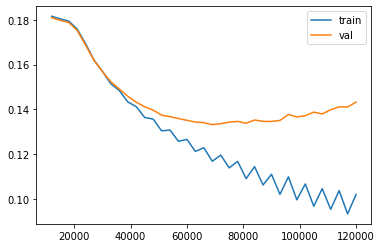

In [18]:
plt.plot(df['checkpoint_id'][3:], df['tr_metrics.loss'][3:], label='train')
plt.plot(df['checkpoint_id'][3:], df['val_metrics.loss'][3:], label='val')
plt.legend()

In [20]:

proba = predict_proba(
    model, 
    val_dataset, 
    batch_size = args.eval_batch_size, 
    device = args.device
)
y_true = val_dataset[:]['y_true'].numpy()

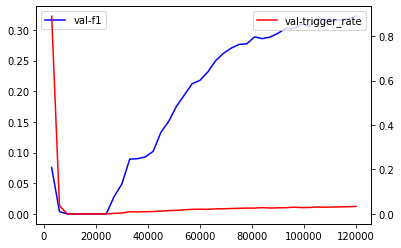

In [21]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(df['checkpoint_id'], 
         df['val_metrics.macro_f1'], 
         label='val-f1', c='blue')
ax2.plot(df['checkpoint_id'], 
         df['val_metrics.trigger_rate'], 
         label='val-trigger_rate', c='red')

ax1.legend()
ax2.legend()

In [22]:
roc_auc_score(y_true, proba, average='macro')

0.8320227124120544

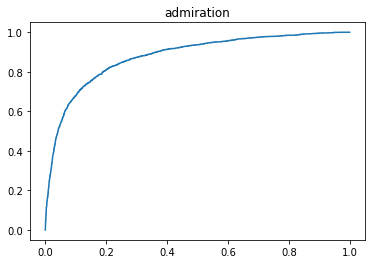

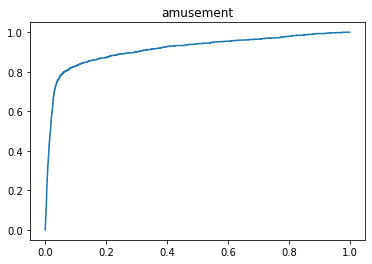

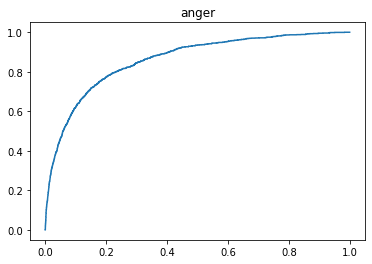

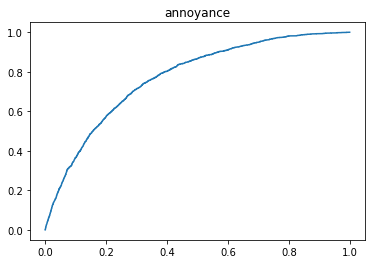

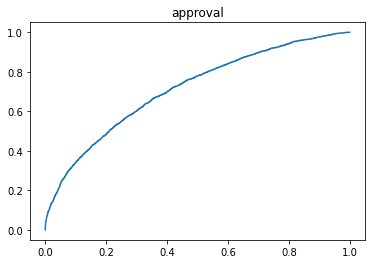

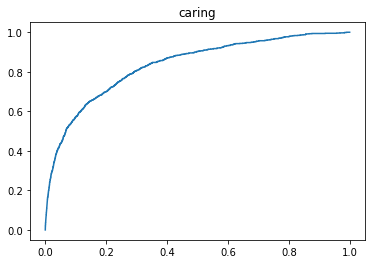

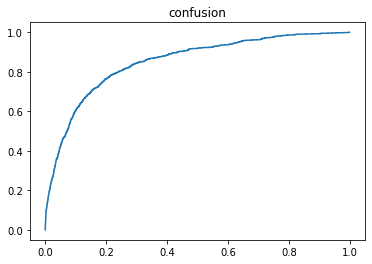

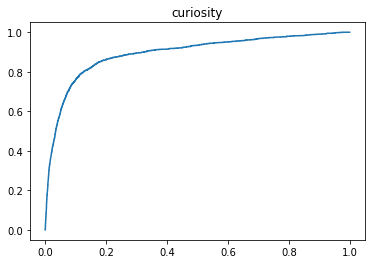

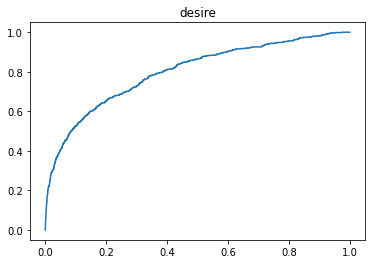

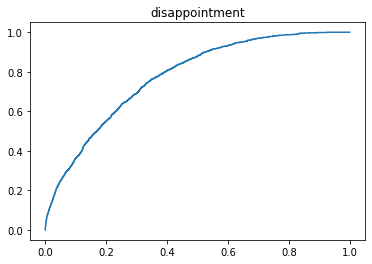

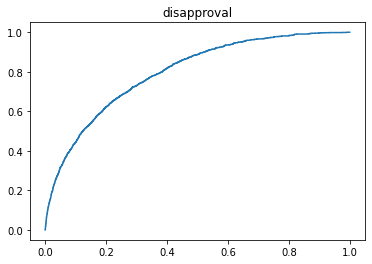

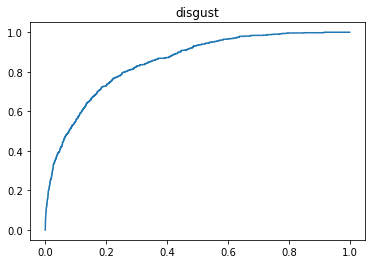

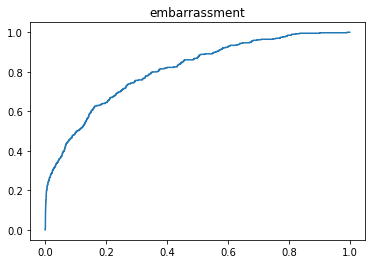

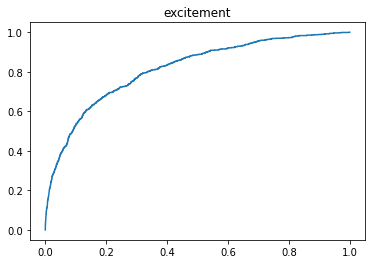

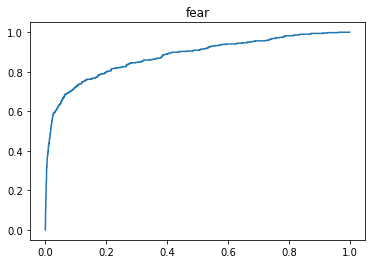

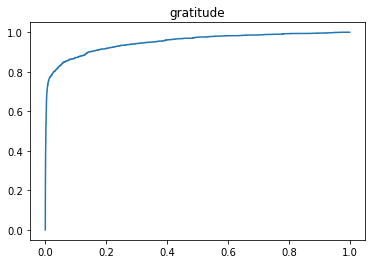

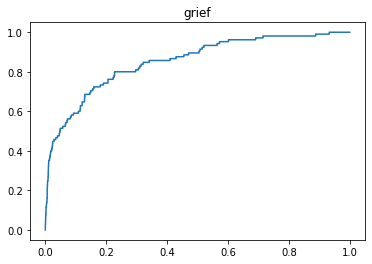

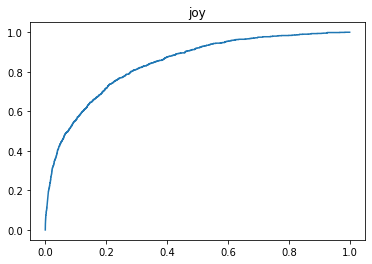

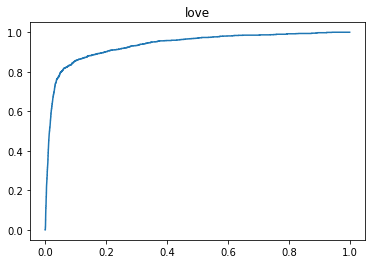

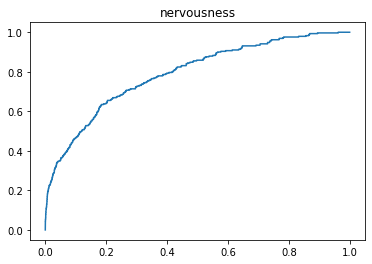

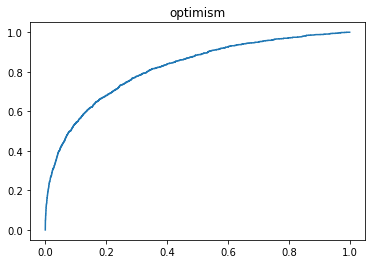

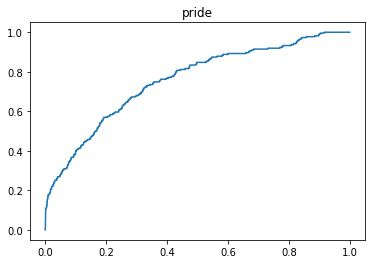

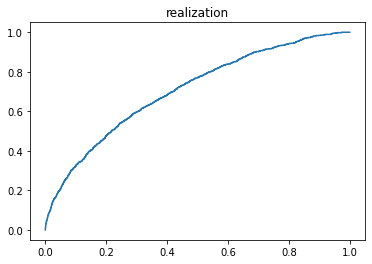

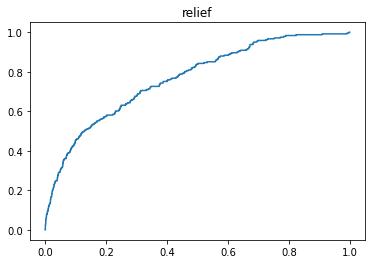

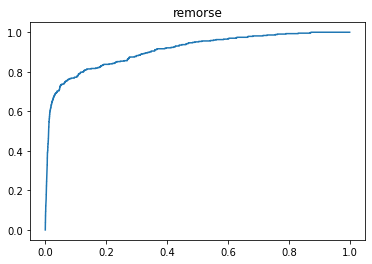

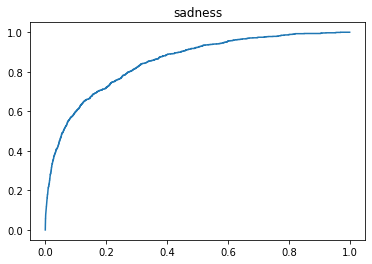

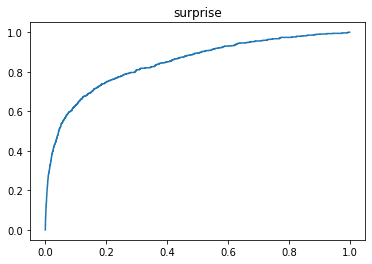

In [23]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


for i, emt in enumerate(args.emotions):
    fpr, tpr, _ = roc_curve(y_true[:, i], proba[:, i])
    plt.plot(fpr, tpr)
    plt.title(emt)
    plt.show()


In [ ]:
proba_to_emotion(
    proba_on_examples([
        'fuck cloud', 
        'yeet'
    ], model), 
    0.4, 
    args.emotions)